In [1]:
%load_ext autoreload
%autoreload 2

import multiprocessing
import os
import pickle

os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count={}".format(
    multiprocessing.cpu_count()
)

import blackjax
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from corner import corner
from jax import jit
from jaxoplanet import orbits
from jaxoplanet.light_curves import LimbDarkLightCurve
from jaxopt import ScipyBoundedMinimize
from tensorflow_probability.substrates.jax.bijectors import Log
from tensorflow_probability.substrates.jax.distributions import (
    Normal,
    TransformedDistribution,
    Uniform,
)

from inference import log_likelihood_function
from kernelsearch import describe_kernel, get_trainables
from mcmc import nuts_warmup, run_mcmc
from util import calculate_example_lightcurve

rng_key = jax.random.PRNGKey(42)

## LOAD DATA AND MODEL

In [19]:
(
    t_train,
    lc_train,
    train_mask,
    t,
    lightcurve,
    systematics,
    noise,
    mask,
) = calculate_example_lightcurve()

model_name = "gpmodel"
with open(f"saved/{model_name}", "rb") as file:
    model = pickle.load(file)

describe_kernel(model)

'(Periodic * Linear * Linear) + Periodic'

In [16]:
# center data
lc_train = lc_train - jnp.mean(lc_train)

## FIT LC

In [4]:
@jit
def lc_model(t, log_params):
    params = jnp.exp(log_params)

    # The light curve calculation requires an orbit
    orbit = orbits.keplerian.Body(
        period=15,
        radius=params[0],
        inclination=jnp.deg2rad(89),
        time_transit=0,
    )

    lc = LimbDarkLightCurve([params[1], params[2]]).light_curve(orbit, t=t)
    return lc

In [5]:
initial_position = {
    "gp_parameter": get_trainables(model, unconstrain=True),
    "lc_parameter": jnp.log(jnp.asarray([0.2, 0.2, 0.5])),
}

(lower_bounds, upper_bounds) = (
    {
        "gp_parameter": -jnp.inf * jnp.ones_like(initial_position["gp_parameter"]),
        "lc_parameter": jnp.array([-10.0, -10.0, -10.0]),
    },
    {
        "gp_parameter": jnp.inf * jnp.ones_like(initial_position["gp_parameter"]),
        "lc_parameter": jnp.array([0.0, 0.0, 0.0]),
    },
)

param_priors = {
    "gp_parameter": Normal(loc=initial_position["gp_parameter"], scale=1),
    "lc_parameter": TransformedDistribution(
        distribution=Uniform(
            low=jnp.exp(lower_bounds["lc_parameter"]),  # type: ignore
            high=jnp.exp(upper_bounds["lc_parameter"]),  # type: ignore
        ),
        bijector=Log(),
    ),
}

In [6]:
log_likelihood = log_likelihood_function(
    model.unconstrain(),
    lc_model,
    t_train,
    lc_train,
    train_mask,
    fix_gp=False,
    compile=True,
)


@jit
def log_priors(params):
    gp_log_priors = param_priors["gp_parameter"].log_prob(params["gp_parameter"])
    lc_log_priors = param_priors["lc_parameter"].log_prob(params["lc_parameter"])
    return jnp.sum(gp_log_priors) + jnp.sum(lc_log_priors)


@jit
def log_probability(params):
    return log_likelihood(params) + log_priors(params)


neg_log_probability = jit(lambda params: -log_probability(params))

In [7]:
lbfgsb = ScipyBoundedMinimize(fun=neg_log_probability, method="l-bfgs-b")
lbfgsb_sol = lbfgsb.run(initial_position, bounds=(lower_bounds, upper_bounds))

print("Best fit parameter: ", jnp.exp(lbfgsb_sol.params["lc_parameter"]))

Best fit parameter:  [0.10545647 0.19820522 0.31743448]


## RUN MCMC

In [8]:
# Adapted from BlackJax's introduction notebook.
num_adapt = 500
num_samples = 500
num_chains = 8

rng_key, warmup_key, sample_key = jax.random.split(rng_key, 3)

state, parameters = nuts_warmup(
    warmup_key,
    log_probability,
    initial_position,
    num_steps=num_adapt,
)

initial_positions = {
    "gp_parameter": jnp.tile(state.position["gp_parameter"], (num_chains, 1)),
    "lc_parameter": jnp.tile(state.position["lc_parameter"], (num_chains, 1)),
}

final_state, state_history, info_history = run_mcmc(
    sample_key,
    log_probability,
    parameters,
    initial_positions,
    num_steps=num_samples,
)

Running window adaptation


In [9]:
np.save(
    f"saved/{model_name}_parameter.npy",
    np.array(state_history.position["lc_parameter"].reshape(-1, 3)),
)

Done


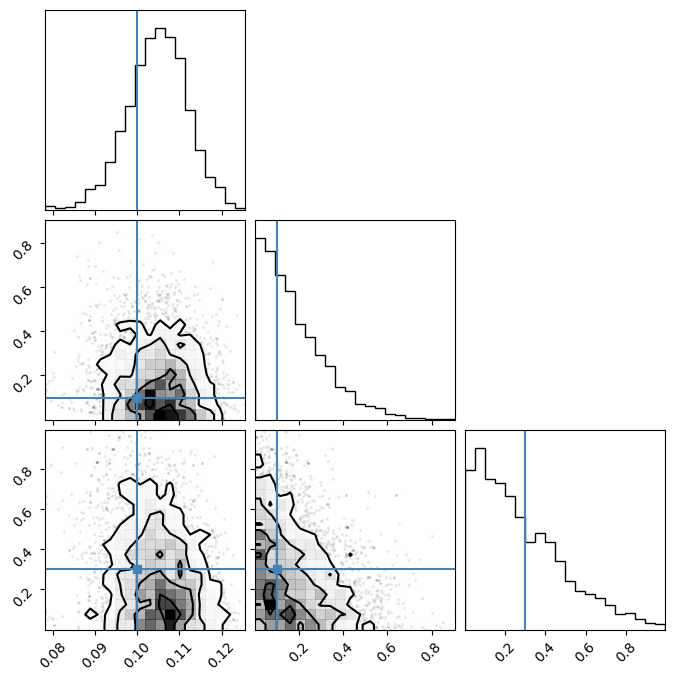

In [10]:
corner(
    np.exp(np.array(state_history.position["lc_parameter"].reshape(-1, 3))),
    truths=jnp.array([0.1, 0.1, 0.3]),
)
print("Done")